In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [2]:
# this code has loading error at this moment
# 12-30-2020
# so I replaced code below with the cells next on it
'''
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
'''

"\n(train_ds, val_ds, test_ds), metadata = tfds.load(\n    'tf_flowers',\n    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],\n    with_info=True,\n    as_supervised=True,\n)\n"

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [8]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

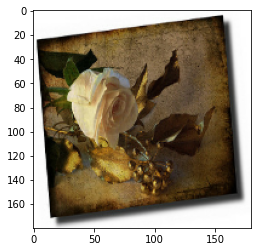

In [9]:
for images, labels in train_ds.take(1):
    break
#image = images[0]
results = resize_and_rescale(images)
_ = plt.imshow(results[0])

In [10]:
print("Min and max pixel values: ", results[0].numpy().min(), results.numpy().max())

Min and max pixel values:  0.0 1.0


In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
image = tf.expand_dims(images[0],0)

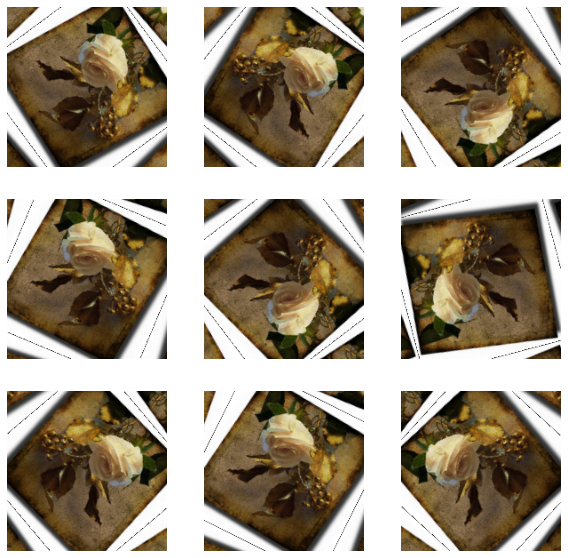

In [13]:
plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

### Two options for using preprocessing layers

1. make it as a part of the model<br>
   i) GPU accelerator benefit<br>
   ii) Including preprocessing layer when deploying<br>
   ** data augmentation layers will be inactive when model.evaluate or model.predict
   
2. apply it to dataset<br>
   i) only works with CPU<br>
   ii) has to re-code preprocessing layers when deploying<br>
   ** data augmentation has to be applied only on training dataset

In [14]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment =False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    #ds = ds.batch(batch_size)
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
        
    #return ds.prefetch(buffer_sizes=AUTOTUNE)
    return ds

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

In [16]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names))
])

In [17]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [18]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 10s 112ms/step - loss: 1.3613 - accuracy: 0.4411 - val_loss: 1.0589 - val_accuracy: 0.5831
Epoch 2/5
92/92 [==============================] - 8s 88ms/step - loss: 1.0404 - accuracy: 0.5848 - val_loss: 0.9553 - val_accuracy: 0.6049
Epoch 3/5
92/92 [==============================] - 8s 91ms/step - loss: 0.9484 - accuracy: 0.6250 - val_loss: 0.9209 - val_accuracy: 0.6349
Epoch 4/5
92/92 [==============================] - 8s 89ms/step - loss: 0.8870 - accuracy: 0.6465 - val_loss: 0.9212 - val_accuracy: 0.6090
Epoch 5/5
92/92 [==============================] - 8s 87ms/step - loss: 0.8381 - accuracy: 0.6727 - val_loss: 0.8287 - val_accuracy: 0.6621


In [19]:
loss, acc = model.evaluate(val_ds)
print('Accuracy', acc)

23/23 [==============================] - 2s 91ms/step - loss: 0.8287 - accuracy: 0.6621
Accuracy 0.6621253490447998


In [20]:
def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255-x)
    else:
        x
    return x

In [21]:
def random_invert(factor = 0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

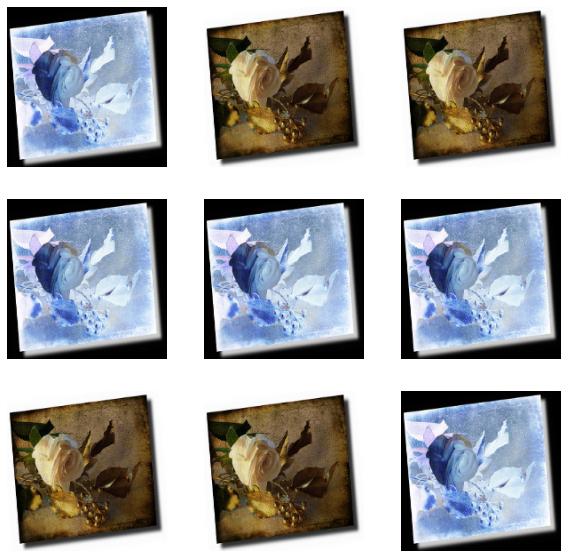

In [22]:
plt.figure(figsize=(10,10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

In [23]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
        
    def call(self, x):
        return random_invert_img(x)

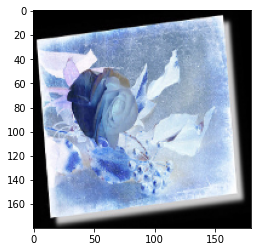

In [26]:
_ = plt.imshow(RandomInvert()(image)[0].numpy().astype('uint8'))

Text(0.5, 1.0, 'roses')

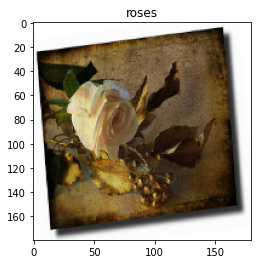

In [34]:
plt.imshow(image[0].numpy().astype('uint8'))
label = labels[0]
plt.title(class_names[label])

In [35]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original.numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented.numpy().astype('uint8'))

In [37]:
image = image[0]

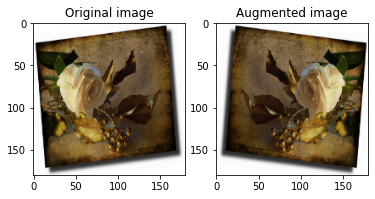

In [38]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

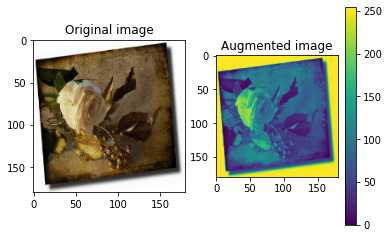

In [40]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar();

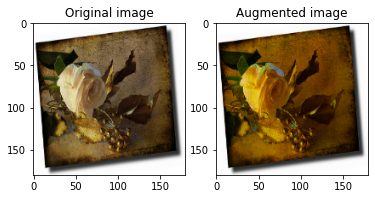

In [41]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

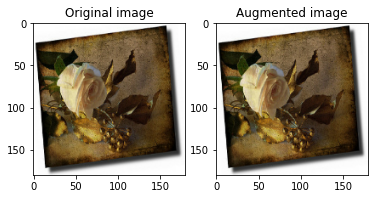

In [55]:
bright = tf.image.adjust_brightness(image, 0.2)
visualize(image, bright)

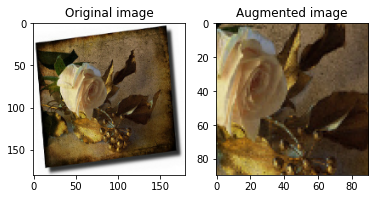

In [51]:
cropped = tf.image.central_crop(image, central_fraction = 0.5)
visualize(image, cropped)

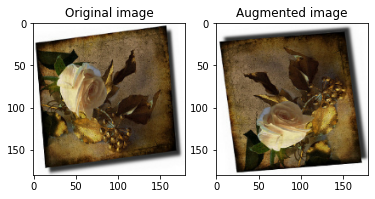

In [52]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [56]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [57]:
def augment(image, label):
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZSE + 6, IMG_SIZE + 6)
    image = tf.image.random_crop(image, size = [IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta = 0.5)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [59]:
train_ds.map(resize_and_rescale)

<MapDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>